# MAREVA - miniprojet: Image segmentation combined with depth maps for industrial safety applications

*Authors: Emma Bou Hanna & Sebastian Partarrieu*

## Installs and data imports

In [2]:
import torch
torch.__version__

'1.13.1+cpu'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

ModuleNotFoundError: No module named 'google.colab'

In [37]:
# %cd gdrive/MyDrive/MinesParis/MAREVA/mini-projet/
%cd ../mini-projet

/content/gdrive/.shortcut-targets-by-id/1nZRuqpcjxPM7oEdIkQeR7REHOuCr2ZUz/mini-projet


In [2]:
!pip install transformers

     ---------------------------------------- 7.1/7.1 MB 873.5 kB/s eta 0:00:00
     -------------------------------------- 224.5/224.5 kB 1.1 MB/s eta 0:00:00
     -------------------------------------- 268.0/268.0 kB 1.2 MB/s eta 0:00:00
     ---------------------------------------- 3.5/3.5 MB 1.4 MB/s eta 0:00:00
     -------------------------------------- 160.1/160.1 kB 1.2 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0 -> 23.1.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib import cm
import torch
import numpy as np
from collections import defaultdict

In [4]:
from transformers import MaskFormerFeatureExtractor, MaskFormerForInstanceSegmentation
import PIL
# import request

In [5]:
from typing import Union, List, Dict
import os
import glob

## Running on predownloaded dataset

In [6]:
feature_extractor = MaskFormerFeatureExtractor.from_pretrained("facebook/maskformer-swin-base-coco")
model = MaskFormerForInstanceSegmentation.from_pretrained("facebook/maskformer-swin-base-coco")

b:\myprograms\python\lib\site-packages\transformers\models\maskformer\feature_extraction_maskformer.py:28: FutureWarning: The class MaskFormerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use MaskFormerImageProcessor instead.
  warnings.warn(
b:\myprograms\python\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:401: FutureWarning: The `size_divisibility` argument is deprecated and will be removed in v4.27. Please use `size_divisor` instead.
  warnings.warn(
b:\myprograms\python\lib\site-packages\transformers\models\maskformer\image_processing_maskformer.py:408: FutureWarning: The `max_size` argument is deprecated and will be removed in v4.27. Please use size['longest_edge'] instead.
  warnings.warn(


KeyboardInterrupt: 

In [28]:
### helpers

def extract_humans(segmentation, segments_info):
  humans = torch.zeros(segmentation.shape)
  for segment in segments_info:
    segment_id, segment_label_id = segment['id'], segment['label_id']
    if segment_label_id == 0:
      humans[segmentation == segment_id] = segment_id
  return humans

def get_distance(depth_img):
  bit_swap = np.array(depth_img, dtype=np.int16).byteswap()
  b = 7.5e-2
  f = 594
  doff = 1090

  map_depth_to_distance = lambda x: b*f/(1/8*(doff - x))
  distance_values = map_depth_to_distance(bit_swap)
  return(distance_values)

def determine_distances_of_humans(humans, depth_img):
  distance_values = get_distance(depth_img)
  all_humans_id = humans.unique()
  all_humans_id = all_humans_id[all_humans_id > 0]
  human_distances = {}
  for hum in all_humans_id:
    human_distances[hum.item()] = np.median(distance_values[humans == hum])
  return(human_distances)

def display_humans_with_distances(img, humans, dist, savepath=None, i=0):
  plt.figure(figsize=(8,8))
  plt.imshow(humans > 0, cmap='magma')
  plt.imshow(img, alpha=.6)
  for hum in dist:
    hum_masked = humans == hum
    hum_coord = hum_masked.argwhere().numpy()
    y, x = np.median(hum_coord[:,0]), np.median(hum_coord[:,1])
    x += 1
    y += 1
    plt.text(x, y, f"Distance {np.round(dist[hum],2)}m", rotation=270, c="white")
  if savepath:
    plt.axis('off')
    plt.savefig(savepath+f'{i}.png')
    plt.close()
  else:
    plt.show()

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [30]:
model.to(device)

MaskFormerForInstanceSegmentation(
  (model): MaskFormerModel(
    (pixel_level_module): MaskFormerPixelLevelModule(
      (encoder): MaskFormerSwinBackbone(
        (model): MaskFormerSwinModel(
          (embeddings): MaskFormerSwinEmbeddings(
            (patch_embeddings): MaskFormerSwinPatchEmbeddings(
              (projection): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
            )
            (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
          (encoder): MaskFormerSwinEncoder(
            (layers): ModuleList(
              (0): MaskFormerSwinStage(
                (blocks): ModuleList(
                  (0): MaskFormerSwinLayer(
                    (layernorm_before): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
                    (attention): MaskFormerSwinAttention(
                      (self): MaskFormerSwinSelfAttention(
                        (query): Linear(in_featur

In [31]:
### paths for image sequences with sanity check

root_rgb_path = './data_test/rgb_view0/'
root_depth_path = './data_test/depth_view0/'

rgb_potential_paths = glob.glob(root_rgb_path+'*.ppm')
rgb_paths = []
depth_paths = []

for potential_rgb in rgb_potential_paths:
  file_id = potential_rgb.split('/')[-1].replace('.ppm', '')
  potential_depth = root_depth_path + file_id + '.pgm'
  if os.path.isfile(potential_depth):
    rgb_paths.append(potential_rgb)
    depth_paths.append(potential_depth)

In [32]:
print(torch.cuda.memory_summary())

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |     882 MB |    1061 MB |   26156 MB |   25274 MB |
|       from large pool |     681 MB |     960 MB |   25413 MB |   24731 MB |
|       from small pool |     200 MB |     200 MB |     743 MB |     543 MB |
|---------------------------------------------------------------------------|
| Active memory         |     882 MB |    1061 MB |   26156 MB |   25274 MB |
|       from large pool |     681 MB |     960 MB |   25413 MB |

In [33]:
from torchvision.utils import save_image

In [34]:
ls

data_test/         img_test_segmented.jpg  photo.jpg
Human_robot.ipynb  mask_rcnn_coco.h5       webcam_video_emma.mp4
img_test.jpeg      Mini-projet.ipynb       webcam_video.mp4


In [39]:
### iterating over images to make video
model.eval()

for i, (rgb_img_path, depth_img_path) in enumerate(zip(rgb_paths, depth_paths)):
  file_id = rgb_img_path.split('/')[-1].replace('.ppm', '')
  with torch.no_grad():
    rgb_img = PIL.Image.open(rgb_img_path)
    depth_img = PIL.Image.open(depth_img_path)

    inputs = feature_extractor(images=rgb_img, return_tensors="pt")
    inputs.to(device)

    outputs = model(**inputs)
    result = feature_extractor.post_process_panoptic_segmentation(outputs,
                                                                  target_sizes=[rgb_img.size[::-1]])[0]
    
    #del inputs, outputs
    humans = extract_humans(**result)
    save_image(humans, './seg_mask/'+file_id+'.png')
    #del result
    dist_to_hum = determine_distances_of_humans(humans, depth_img)
    #display_humans_with_distances(rgb_img, humans, dist_to_hum, savepath=None)
    display_humans_with_distances(rgb_img, humans, dist_to_hum, savepath='./seg_video/', i=file_id)
    #del humans, dist_to_hum
    #torch.cuda.empty_cache()

`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. N

In [ ]:
ls

data_test/         img_test_segmented.jpg  photo.jpg
Human_robot.ipynb  mask_rcnn_coco.h5       webcam_video_emma.mp4
img_test.jpeg      Mini-projet.ipynb       webcam_video.mp4


In [ ]:
for i, (rgb_img_path, depth_img_path) in enumerate(zip(rgb_paths, depth_paths)):
  file_id = rgb_img_path.split('/')[-1].replace('.ppm', '')
  current_path = f'./seg_video/video_{i}.png'
  new_path = './seg_video/'+file_id+'.png'
  os.rename(current_path, new_path)

In [ ]:
test = glob.glob('./seg_video/*.png')

In [ ]:
sorted_files = sorted(test, key=lambda x: int(x.split('_')[2]))

In [ ]:
import cv2

In [1]:
%ls

 Volume in drive B is Main
 Volume Serial Number is 04FE-433E

 Directory of B:\Git\live-kinect-master

06/06/23  12:37    <DIR>          .
06/06/23  12:37    <DIR>          ..
05/31/23  20:33             1,928 .gitignore
05/31/23  20:37    <DIR>          .ipynb_checkpoints
05/31/23  20:33    <DIR>          docs
05/31/23  20:33             2,403 intel_example1.py
05/31/23  20:33             6,388 intel_example2.py
05/31/23  20:33             3,556 intel_example3.py
05/31/23  20:33             7,454 intel_real_sense1.py
05/31/23  20:33            10,393 kinect_real_time.py
05/31/23  20:33             1,097 LICENSE
06/01/23  00:42           266,848 live-segmentation-cpu.ipynb
05/31/23  20:33    <DIR>          models
05/31/23  21:15    <DIR>          openvino_notebooks
05/31/23  20:33             1,200 point_cloud_to_video.py
05/31/23  20:33             7,311 README.md
05/31/23  20:33             1,643 requirements_openvino.txt
06/06/23  12:37           269,910 swi-vit-segmentation-webcam

In [ ]:
img_array = []
for filename in sorted_files:
  img = cv2.imread(filename)
  #rotate
  img = cv2.rotate(img, cv2.ROTATE_90_COUNTERCLOCKWISE)
  height, width, layers = img.shape
  size = (height, width) 
  img_array.append(img)

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('segmented_video_one_color.mp4', fourcc, 15.0, size)

for i in range(len(img_array)):
    out.write(img_array[i])
out.release()

## Running on live webcam

In [ ]:
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import io
import html
import time
import PIL

In [ ]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: numpy array
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  img = cv2.imdecode(jpg_as_np, flags=1)
  return img

def bbox_to_bytes(mask):
  """
  Params:
          mask: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(mask)
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
## test taking a picture
def take_photo(model, feature_extractor,
               filename='photo.jpg', quality=0.8):
  js = Javascript(
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    )
  display(js)

  model.eval()
  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get numpy array
  img = js_to_image(data) 

  with torch.no_grad():
    inputs = feature_extractor(images=img, return_tensors="pt")
    inputs.to(device)

    outputs = model(**inputs)
    result = feature_extractor.post_process_panoptic_segmentation(outputs,
                                                                  target_sizes=[(480, 640)])[0]
    humans = extract_humans(**result)
    humans = (humans > 0).numpy()

  color = np.array([0,255,0], dtype='uint8')
  masked_img = np.where(humans[...,None], color, img)
  final_img = cv2.addWeighted(img, 0.8, masked_img, 0.2, 0)
  # save image
  cv2.imwrite(filename, final_img)

  return filename


<IPython.core.display.Javascript object>

`label_ids_to_fuse` unset. No instance will be fused.


Saved to photo.jpg


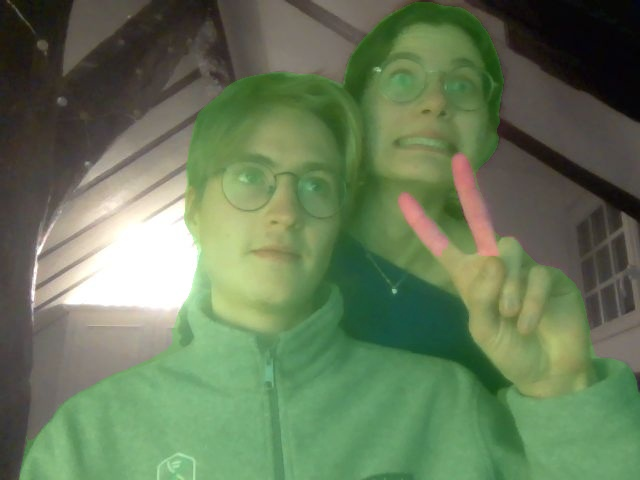

In [ ]:
try:
  filename = take_photo(model, feature_extractor,
                      'photo.jpg')
  
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript(
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 640, 480);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 640; //video.videoWidth;
      captureCanvas.height = 480; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    )

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
video_test = []

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'

bbox = ''
count = 0
model.eval()

while True:
    js_reply = video_frame(label_html, bbox)
    if not js_reply:
      break
  
    # convert JS response to OpenCV Image
    img = js_to_image(js_reply["img"])

    with torch.no_grad():
      inputs = feature_extractor(images=img, return_tensors="pt")
      inputs.to(device)

      outputs = model(**inputs)
      result = feature_extractor.post_process_panoptic_segmentation(outputs,
                                                                    target_sizes=[(480, 640)])[0]
      humans = extract_humans(**result)
      humans = (humans > 0).numpy()

    color = np.array([0,255,0], dtype='uint8')
    masked_img = np.where(humans[...,None], color, img)
    final_img = cv2.addWeighted(img, 0.8, masked_img, 0.2, 0)

    video_test.append(final_img)

    bbox_bytes = bbox_to_bytes(final_img)
    bbox = bbox_bytes
    


<IPython.core.display.Javascript object>

`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.
`label_ids_to_fuse` unset. No instance will be fused.


In [ ]:
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('webcam_video.mp4', fourcc, 5.0, (640, 480))

for i in range(len(video_test)):
    out.write(video_test[i])
out.release()

In [ ]:
# url = "http://images.cocodataset.org/val2017/000000039769.jpg"
# image = Image.open(requests.get(url, stream=True).raw)